# Imports

In [1]:
from random import random, sample
from time import time
from copy import deepcopy

import torch
import torch.nn as nn
from torchvision import transforms, datasets

import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device == torch.device("cuda:0"):
    print(device, torch.cuda.get_device_name(0))
else:
    print("CPU")

cuda:0 Tesla T4


In [3]:
print("Pytorch version:", torch.__version__)

Pytorch version: 2.0.1+cu118


# Parameters

In [4]:
valid_data_size = 0.1
batch_size = 32
epochs = 10
lr = 0.001
weight_decay = 1e-5

# Load Dataset

In [5]:
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [6]:
indices = list(range(len(train_data)))
np.random.shuffle(indices)
split = int(np.floor((1 - valid_data_size) * len(train_data)))
train_sample = torch.utils.data.SubsetRandomSampler(indices[:split])
valid_sample = torch.utils.data.SubsetRandomSampler(indices[split:])

trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sample, batch_size=batch_size, num_workers=2)
validloader = torch.utils.data.DataLoader(train_data, sampler=valid_sample, batch_size=batch_size, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [7]:
classes = (
    'plane',
    'car',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
)

# Show Samples

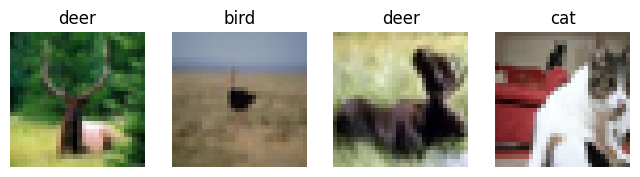

In [8]:
fig, ax = plt.subplots(1, 4, figsize=(8, 8))
for i in range(4):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    ax[i].set_title(classes[train_data[sample_idx][1]])
    ax[i].imshow(train_data[sample_idx][0].swapaxes(0,1).swapaxes(1,2))
    ax[i].axis(False)
plt.show()

# Functions

## Progrss Bar

In [9]:
def progress_bar(epochs=None, batch=None, addition_output="", n_samples=None, lenght_bar = 40, reset=False):
    def print_result(percent, end=False):
        if end:
            end = '\n'
        else:
            end = ''
        space = lenght_bar - progress_bar.percent - 1
        print(
            f'\r epoch {progress_bar.epochs}: ' \
            f'[{"="*progress_bar.percent}>{" "*space}] {percent:>3d}%  ' \
            f'time:{int(progress_bar.take_time)}s - {addition_output}',
            end=end
        )

    if reset:
        progress_bar.percent = 0
        progress_bar.last_time = time()
        progress_bar.take_time = 0
        progress_bar.n_samples = n_samples
        progress_bar.epochs = epochs
        print_result(0)
        return
    if batch == progress_bar.n_samples:
        print_result(100, True)
        return
    new_percent = int((batch / progress_bar.n_samples) * lenght_bar)
    actual_percent = int((progress_bar.percent / lenght_bar) * 100)
    if progress_bar.percent < new_percent:
        progress_bar.percent = new_percent
    progress_bar.take_time += time() - progress_bar.last_time
    progress_bar.last_time = time()
    print_result(actual_percent)

## Test Function

In [10]:
def test(model, test_loader, loss_function=None, return_confusion=False):
    accuracy = 0
    total = 0
    running_loss = 0
    if return_confusion:
        confusion_matrix = np.zeros((len(classes), len(classes)), dtype=np.int32)
    with torch.no_grad():
        for (images, _) in test_loader:
            images = images.to(device, non_blocking=True)
            # predict
            out, mu, var = model(images)
            total += images.size(0)
            if loss_function is not None:
                loss = loss_function(out, images, mu, var)
                # loss = loss_function(out, images)
                running_loss += loss.item()
    res = [(accuracy / total * 100.)]
    if loss_function is not None:
        res += [(running_loss/len(test_loader))]
    return res

## Train function

In [11]:
def train(model, train_loader, validation_loader, optim, loss_function, epochs):
    losses = []
    val_losses = []
    accuracies = []
    val_accuracies = []
    best_accuracy = 0
    total_time_train = 0

    for i in range(epochs):
        progress_bar(i+1, n_samples=len(train_loader), reset=True)
        running_loss = 0
        model.zero_grad()
        accuracy = 0
        total_size = 0
        for batch, (images, _) in enumerate(train_loader):
            # move to target device (gpu)
            images = images.to(device, non_blocking=True)
            # predict
            out, mu, var = model(images)
            # cal loss
            loss = loss_function(out, images, mu, var)
            # loss = loss_function(out, images)
            loss.backward()
            running_loss += loss.data
            # optimazer step
            optim.step()
            model.zero_grad()
            # update progress bar
            progress_bar(batch=batch, addition_output=f"loss={running_loss/(batch+1):>.4f}")

        total_time_train += progress_bar.take_time
        # append to history
        losses.append((running_loss / len(train_loader)).item())

        # test validation data
        val_accuracy, val_loss = test(model, validation_loader, loss_function)
        val_losses.append(val_loss)

        # step progress_bar
        addition_output = f"loss = {losses[-1]:>.4f} - val_loss = {val_losses[-1]:>.4f}"
        progress_bar(batch=len(train_loader), addition_output=addition_output)

    print(f"----------\n total time for train: {total_time_train / 60.}min")
    return {"loss": losses, "val_loss": val_losses}

## Show Sample Predict

In [12]:
def show_predicts(model, test_data, n_test=5):
    fig, ax = plt.subplots(2, n_test, figsize=(20, 6))
    model.eval()  # Sets the module in evaluation mode not train mode
    with torch.no_grad():
        for i in range(n_test):
            rand_index = int(random() * (len(test_data) - 1))
            image = test_data[rand_index][0]

            ax[0, i].set_title(f"image")
            ax[0, i].imshow(image.swapaxes(0,1).swapaxes(1,2))
            ax[0, i].axis(False)

            image = image.to(device, non_blocking=True)
            image = image.unsqueeze(0)
            out, mu, var = model(image)

            ax[1, i].set_title(f"predict image")
            ax[1, i].imshow(out.squeeze().swapaxes(0,1).swapaxes(1,2).cpu().numpy())
            ax[1, i].axis(False)

            fig.tight_layout()
    plt.show()

# Model

## Encoder

In [13]:
class Encoder(nn.Module):
    def __init__(self, latent_size = 4096):
        super(Encoder, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=12, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(True),
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU(True),
            nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(True),

            nn.Sequential(
                nn.Flatten(),
                nn.LazyLinear(latent_size),
            )
        )

    def forward(self, inputs):
        return self.network(inputs)

## Decoder

In [14]:
class Decoder(nn.Module):
    def __init__(self, latent_size=4096):
        super(Decoder, self).__init__()
        self.pre_decoder = nn.Sequential(
                nn.Linear(latent_size, 4*4*48),
        )

        self.network = nn.Sequential(
            nn.ConvTranspose2d(in_channels=48, out_channels=24, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=24, out_channels=12, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=12, out_channels=3, kernel_size=4, stride=2, padding=1, bias=True),
            nn.Sigmoid(),
        )

    def forward(self, inputs):
        out = self.pre_decoder(inputs)
        out = out.reshape(-1,48,4,4)
        out = self.network(out)
        return out

## Variational AutoEncoder

VAE structure
![VAE decode structure](https://raw.githubusercontent.com/belepi93/vae-cf-pytorch/master/pics/vae.png)


$$ Encoder = q_{\phi} (z \mid x^{(i)})$$
$$ Decoder = p_{\theta} (x^{(i)} \mid z) $$
$$ P(z) = Normal(0,1) = \epsilon $$

---

$$ Loss = Reconstruct Loss + Regularizer $$
$$ L(\Theta, \phi, x^{(i)}) = E_{z \sim q_{\theta}(z \mid x^{(i)})}[\log p_{\theta} (x^{(i)} \mid z)] - D_{KL} (q_{\phi} (z \mid x^{(i)} \mid\mid p_{\theta} (z) )) $$

In [15]:
class VAE(nn.Module):
    def __init__(self, latent_size = 4096, var_space = 4096):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_size)

        self.fc_mu = nn.Linear(latent_size, var_space)
        self.fc_var = nn.Linear(latent_size, var_space)

        self.decoder = Decoder(var_space)

    def compute_Z(self, mu, var):
        # reparameterise
        std = torch.exp(var * 0.5)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, inputs):
        out = self.encoder(inputs)
        mu = self.fc_mu(out)
        var = self.fc_var(out)
        z = self.compute_Z(mu, var)
        return (self.decoder(z), mu, var)

    @staticmethod
    def loss_function(pred, act, mu, var, kl_weight = 0.01):
        MSE = nn.functional.mse_loss(pred, act, reduction='sum')
        KLD = 0.5 * torch.sum(var.exp() - var - 1 + mu.pow(2))
        return (MSE + kl_weight * KLD) / 1000.

# Create Model & Train

In [16]:
model = VAE(1024, 1024).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr ,weight_decay=weight_decay)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [17]:
history = train(model, trainloader, validloader, optimizer, VAE.loss_function, epochs)

 epoch 1: [=======================================>] 100%  time:24s - loss = 1.7559 - val_loss = 1.3242
 epoch 2: [=======================================>] 100%  time:16s - loss = 1.2243 - val_loss = 1.1470
 epoch 3: [=======================================>] 100%  time:16s - loss = 1.0595 - val_loss = 1.0177
 epoch 4: [=======================================>] 100%  time:16s - loss = 0.9439 - val_loss = 0.9008
 epoch 5: [=======================================>] 100%  time:16s - loss = 0.8755 - val_loss = 0.8375
 epoch 6: [=======================================>] 100%  time:18s - loss = 0.8266 - val_loss = 0.7934
 epoch 7: [=======================================>] 100%  time:16s - loss = 0.7898 - val_loss = 0.7711
 epoch 8: [=======================================>] 100%  time:24s - loss = 0.7558 - val_loss = 0.7272
 epoch 9: [=======================================>] 100%  time:16s - loss = 0.7292 - val_loss = 0.7104
 epoch 10: [=======================================>] 100%  time

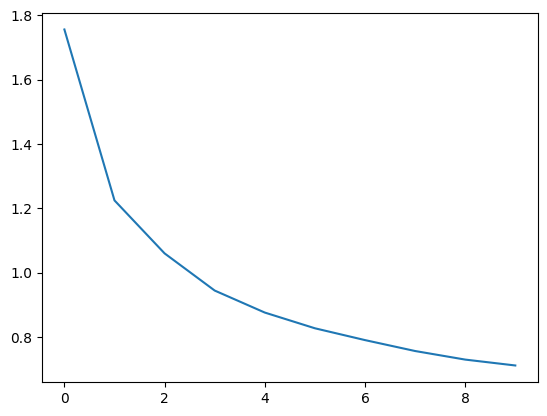

In [18]:
plt.plot(history["loss"])

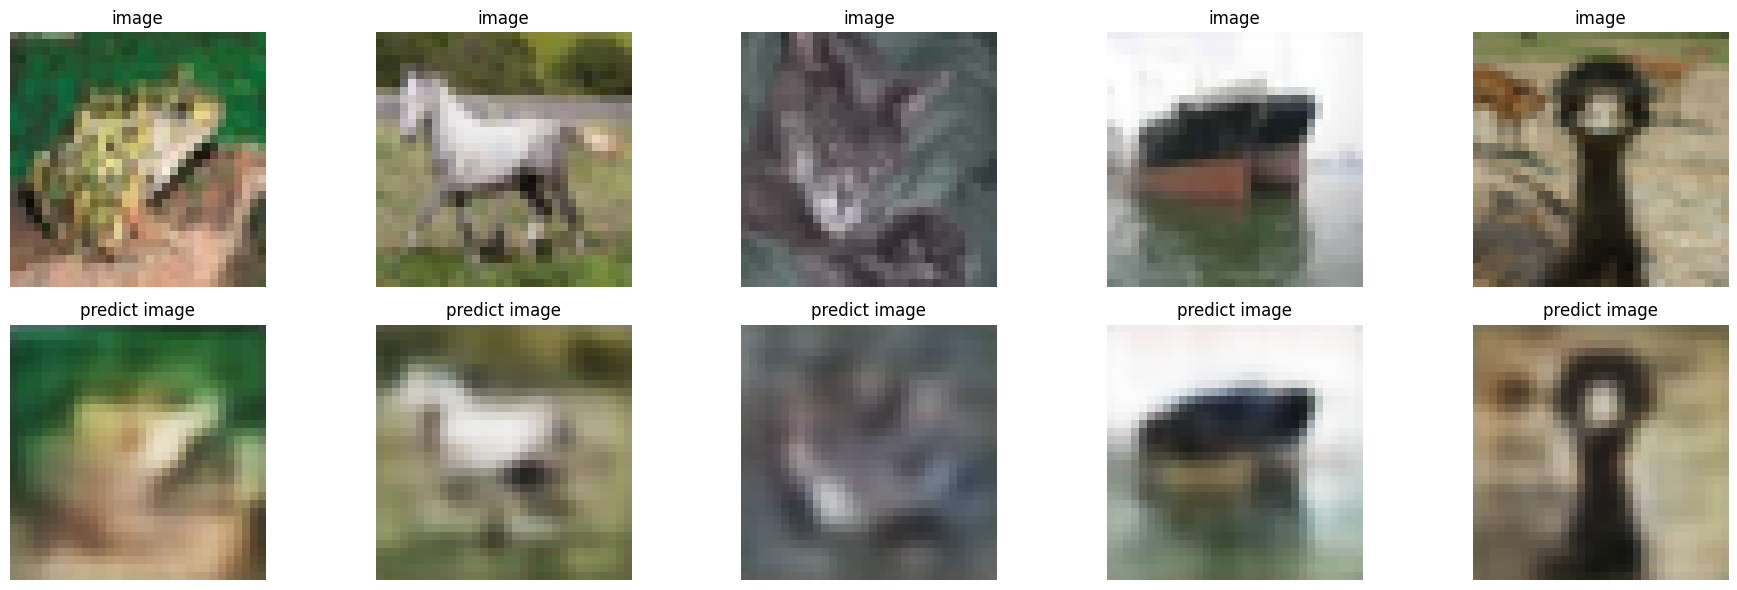

In [19]:
show_predicts(model, test_data)